In [792]:
# Import all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import random
%matplotlib inline

In [793]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### Function for feature building and extraction on natural language data

In [794]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()   
        
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)

        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function 
Test set is using 25

In [795]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# Testing set uses 25: 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

### Fit (and tune) Ridge Regression Classifier

#### alpha=1.0 (default value)

In [796]:
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


## Look at performance on the test set
## MODEL: Ridge Regression Classifier

#### alpha=1.0 (default value)

In [797]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2178, 'TN': 2063, 'FP': 414, 'FN': 345, 'Accuracy': 0.8482, 'Precision': 0.8402777777777778, 'Recall': 0.8632580261593341, 'desc': 'rdg_test'}


## Train set - Default
#### MODEL: Ridge Regression Classifier
alpha=1.0 (default value)

In [798]:
rdg_default = linear_model.RidgeClassifier()
rdg_default.fit(X_train, y_train)

rdg_performance_train_default = BinaryClassificationPerformance(rdg_default.predict(X_train), y_train, 'rdg_train')
rdg_performance_train_default.compute_measures()
print(rdg_performance_train_default.performance_measures)#### MODEL: Ridge Regression Classifier

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


## Test set - Default
#### MODEL: Ridge Regression Classifier
alpha=1.0 (default value)

In [799]:
rdg_performance_test_default = BinaryClassificationPerformance(rdg_default.predict(X_test), y_test, 'rdg_test')
rdg_performance_test_default.compute_measures()
print(rdg_performance_test_default.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2181, 'TN': 2059, 'FP': 418, 'FN': 342, 'Accuracy': 0.848, 'Precision': 0.8391689111196614, 'Recall': 0.8644470868014269, 'desc': 'rdg_test'}


# TRAIN SET - Iterations

## Iteration 1: Train set
alpha=0.5

In [800]:
rdg_0_5 = linear_model.RidgeClassifier(alpha=0.5)
rdg_0_5.fit(X_train, y_train)

rdg_performance_train_0_5 = BinaryClassificationPerformance(rdg_0_5.predict(X_train), y_train, 'rdg_train_0.5')
rdg_performance_train_0_5.compute_measures()
print(rdg_performance_train_0_5.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_0.5'}


## Iteration 2: Train set
alpha=1.5

In [801]:
rdg_1_5 = linear_model.RidgeClassifier(alpha=1.5)
rdg_1_5.fit(X_train, y_train)

rdg_performance_train_1_5 = BinaryClassificationPerformance(rdg_1_5.predict(X_train), y_train, 'rdg_train_1.5')
rdg_performance_train_1_5.compute_measures()
print(rdg_performance_train_1_5.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_1.5'}


## Iteration 3: Train set
alpha=0.1

In [802]:
rdg_0_1 = linear_model.RidgeClassifier(alpha=0.1)
rdg_0_1.fit(X_train, y_train)

rdg_performance_train_0_1 = BinaryClassificationPerformance(rdg_0_1.predict(X_train), y_train, 'rdg_train_0.1')
rdg_performance_train_0_1.compute_measures()
print(rdg_performance_train_0_1.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_0.1'}


## Iteration 4: Train set
alpha=10.0

In [803]:
rdg_10_0 = linear_model.RidgeClassifier(alpha=10.0)
rdg_10_0.fit(X_train, y_train)

rdg_performance_train_10_0 = BinaryClassificationPerformance(rdg_10_0.predict(X_train), y_train, 'rdg_train_10.0')
rdg_performance_train_10_0.compute_measures()
print(rdg_performance_train_10_0.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_10.0'}


## Iteration 5: Train set
alpha=1e-15

In [804]:
rdg_1e_15 = linear_model.RidgeClassifier(alpha=1e-15)
rdg_1e_15.fit(X_train, y_train)

rdg_performance_train_1e_15 = BinaryClassificationPerformance(rdg_1e_15.predict(X_train), y_train, 'rdg_train_1e-15')
rdg_performance_train_1e_15.compute_measures()
print(rdg_performance_train_1e_15.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_1e-15'}


# TEST SET - Iterations

## Iteration 1: Test set
alpha=0.5

In [805]:
rdg_performance_test_0_5 = BinaryClassificationPerformance(rdg_0_5.predict(X_test), y_test, 'rdg_test_0.5')
rdg_performance_test_0_5.compute_measures()
print(rdg_performance_test_0_5.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2181, 'TN': 2062, 'FP': 415, 'FN': 342, 'Accuracy': 0.8486, 'Precision': 0.8401386748844376, 'Recall': 0.8644470868014269, 'desc': 'rdg_test_0.5'}


## Iteration 2: Test set
alpha=1.5

In [806]:
rdg_performance_test_1_5 = BinaryClassificationPerformance(rdg_1_5.predict(X_test), y_test, 'rdg_test_1.5')
rdg_performance_test_1_5.compute_measures()
print(rdg_performance_test_1_5.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2185, 'TN': 2065, 'FP': 412, 'FN': 338, 'Accuracy': 0.85, 'Precision': 0.8413554100885637, 'Recall': 0.8660325009908839, 'desc': 'rdg_test_1.5'}


## Iteration 3: Test set
alpha=0.1

In [807]:
rdg_performance_test_0_1 = BinaryClassificationPerformance(rdg_0_1.predict(X_test), y_test, 'rdg_test_0.1')
rdg_performance_test_0_1.compute_measures()
print(rdg_performance_test_0_1.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2184, 'TN': 2066, 'FP': 411, 'FN': 339, 'Accuracy': 0.85, 'Precision': 0.8416184971098266, 'Recall': 0.8656361474435196, 'desc': 'rdg_test_0.1'}


## Iteration 4: Test set
alpha=10.0

In [808]:
rdg_performance_test_10_0 = BinaryClassificationPerformance(rdg_10_0.predict(X_test), y_test, 'rdg_test_10.0')
rdg_performance_test_10_0.compute_measures()
print(rdg_performance_test_10_0.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2183, 'TN': 2063, 'FP': 414, 'FN': 340, 'Accuracy': 0.8492, 'Precision': 0.8405852907200616, 'Recall': 0.8652397938961554, 'desc': 'rdg_test_10.0'}


## Iteration 5: Test set
alpha=1e-15

In [809]:
rdg_performance_test_1e_15 = BinaryClassificationPerformance(rdg_10_0.predict(X_test), y_test, 'rdg_test_1e-15')
rdg_performance_test_1e_15.compute_measures()
print(rdg_performance_test_1e_15.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2183, 'TN': 2063, 'FP': 414, 'FN': 340, 'Accuracy': 0.8492, 'Precision': 0.8405852907200616, 'Recall': 0.8652397938961554, 'desc': 'rdg_test_1e-15'}


## cache iterations as variables

In [810]:
fits_train = [rdg_performance_train_default, rdg_performance_train_0_5, rdg_performance_train_1_5, rdg_performance_train_0_1, rdg_performance_train_10_0, rdg_performance_train_1e_15]



In [811]:
fits_test = [rdg_performance_test_default, rdg_performance_test_0_5, rdg_performance_test_1_5, rdg_performance_test_0_1, rdg_performance_test_10_0, rdg_performance_test_1e_15]


In [812]:
# create list for each iteration - train vs test
rdg_default = [rdg_performance_train_default, rdg_performance_test_default]
rdg_0_5 = [rdg_performance_train_0_5, rdg_performance_test_0_5]
rdg_1_5 = [rdg_performance_train_1_5, rdg_performance_test_1_5]
rdg_0_1 = [rdg_performance_train_0_1, rdg_performance_test_0_1]
rdg_10 = [rdg_performance_train_10_0, rdg_performance_test_10_0]
rdg_1e_15 = [rdg_performance_train_1e_15, rdg_performance_test_1e_15]

# create list of all iterations and their lists
all_iterations = [rdg_default, rdg_0_5, rdg_1_5, rdg_0_1, rdg_10, rdg_1e_15]

# Plot train vs test

In [813]:
def create_ROC_rgd(iteration, title):
    # create ROC plot for the fit passed as "iteration" with a specific title
    # ROC plot compares performance on train set vs test set
    
    for data_set in iteration:
        FP_rate = data_set.performance_measures['FP'] / data_set.performance_measures['Neg']
        TP_rate = data_set.performance_measures['TP'] / data_set.performance_measures['Pos']

    area = 150
    colors=['red', 'blue']

    fig, ax = plt.subplots()
    
    for data_set in iteration:
        x=data_set.performance_measures['FP'] / data_set.performance_measures['Neg']
        y=data_set.performance_measures['TP'] / data_set.performance_measures['Pos']

        ax.scatter(x, y, s=area, label=data_set.desc, alpha=0.5)

    ax.grid(True)

    plt.axis([0, 1, 0, 1])
    plt.title('ROC plot - RDG: ' + title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    
    image_path = 'plot_images/' + title + '.png'
    fig.savefig(image_path, dpi=fig.dpi)
    
    plt.show()

****************
title rdg_train
****************
rdg_train: TP: 1.0, FP: 0.0
rdg_test: TP: 0.8644470868014269, FP: 0.1687525232135648
False positive rate: 
0.1687525232135648

True positive rate: 
0.8644470868014269


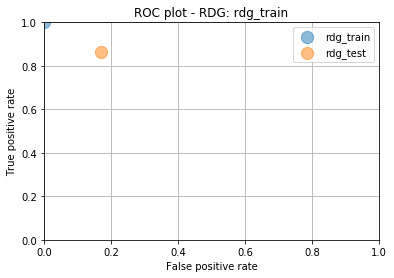

****************
title alpha_0-5
****************
rdg_train_0.5: TP: 1.0, FP: 0.0
rdg_test_0.5: TP: 0.8644470868014269, FP: 0.16754138070246266
False positive rate: 
0.16754138070246266

True positive rate: 
0.8644470868014269


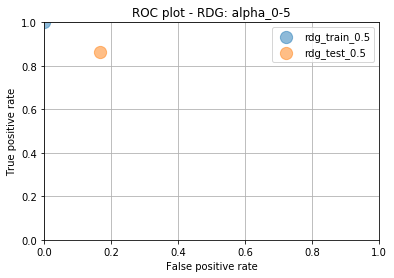

****************
title alpha_1-5
****************
rdg_train_1.5: TP: 1.0, FP: 0.0
rdg_test_1.5: TP: 0.8660325009908839, FP: 0.16633023819136053
False positive rate: 
0.16633023819136053

True positive rate: 
0.8660325009908839


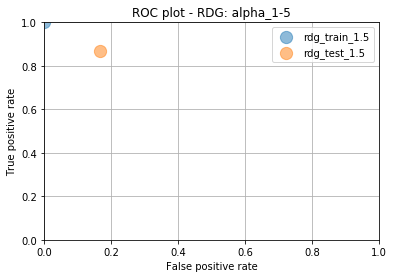

****************
title alpha_0-1
****************
rdg_train_0.1: TP: 1.0, FP: 0.0
rdg_test_0.1: TP: 0.8656361474435196, FP: 0.16592652402099314
False positive rate: 
0.16592652402099314

True positive rate: 
0.8656361474435196


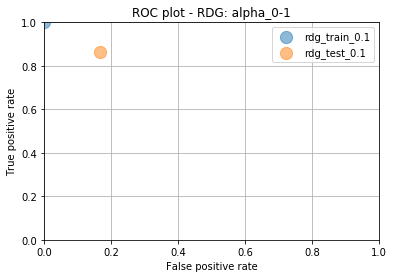

****************
title alpha_10-0
****************
rdg_train_10.0: TP: 1.0, FP: 0.0
rdg_test_10.0: TP: 0.8652397938961554, FP: 0.16713766653209527
False positive rate: 
0.16713766653209527

True positive rate: 
0.8652397938961554


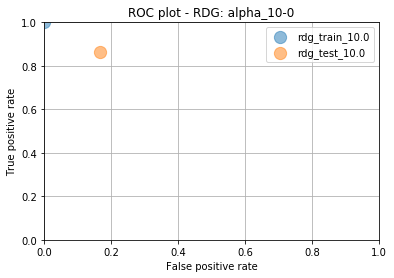

****************
title alpha_1e-15
****************
rdg_train_1e-15: TP: 1.0, FP: 0.0
rdg_test_1e-15: TP: 0.8652397938961554, FP: 0.16713766653209527
False positive rate: 
0.16713766653209527

True positive rate: 
0.8652397938961554


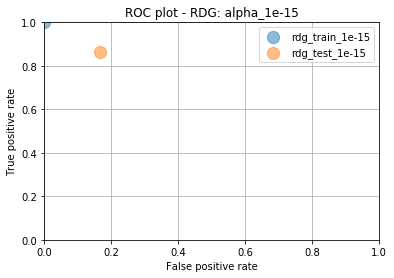

In [814]:
# create the ROC plots for all iterations
for iteration in all_iterations:
    # title:
    title=iteration[0].performance_measures['desc'].replace("rdg_train_", 'alpha_').replace('.','-')
    create_ROC_rgd(iteration, title)

In [815]:
def plot_iterations(fits, title, image_name, limits=False):
    # compares all models' performance - the function is called for train data and test data (below) to compare
    # all models
    
    N = len(fits)
    x = [] # for each fit - fit.performance_measures['FP'] / fit.performance_measures['Neg']
    y = [] # for each fit - fit.performance_measures['TP'] / fit.performance_measures['Pos']

    for fit in fits:
        x.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
        y.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])


    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(N)]
    area = 150

    fig, ax = plt.subplots()

    for fit in fits:
        index = fits.index(fit)
        color=colors[index]
        ax.scatter(x, y, s=area, c=color, label=fit.desc, alpha=0.5)

    ax.grid(True)

    if limits == True:
        # make axes 0 to 1
        ax.set_xlim(left=-0.1)
        ax.set_xlim(right=1.1)
        ax.set_ylim(bottom=0)
        ax.set_ylim(top=1.1)
    
    plt.legend()
    plt.title(title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
    img_path = 'plot_images/' + image_name + '.png'
    
    fig.savefig(img_path, dpi=fig.dpi)

## Plots without reducing n_features

rdg_train: TP: 1.0, FP: 0.0
rdg_train_0.5: TP: 1.0, FP: 0.0
rdg_train_1.5: TP: 1.0, FP: 0.0
rdg_train_0.1: TP: 1.0, FP: 0.0
rdg_train_10.0: TP: 1.0, FP: 0.0
rdg_train_1e-15: TP: 1.0, FP: 0.0


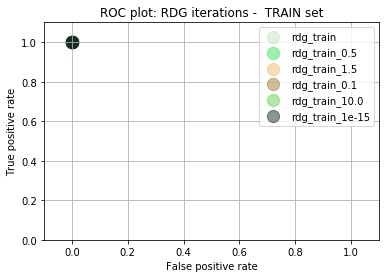

In [816]:
plot_iterations(fits_train, 'ROC plot: RDG iterations -  TRAIN set', 'rdg_train_iterations', limits=True)


rdg_test: TP: 0.8644470868014269, FP: 0.1687525232135648
rdg_test_0.5: TP: 0.8644470868014269, FP: 0.16754138070246266
rdg_test_1.5: TP: 0.8660325009908839, FP: 0.16633023819136053
rdg_test_0.1: TP: 0.8656361474435196, FP: 0.16592652402099314
rdg_test_10.0: TP: 0.8652397938961554, FP: 0.16713766653209527
rdg_test_1e-15: TP: 0.8652397938961554, FP: 0.16713766653209527


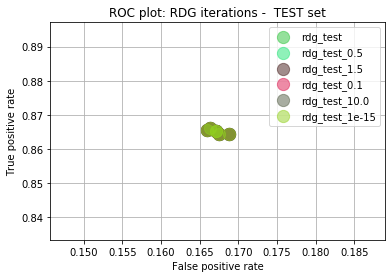

In [817]:
plot_iterations(fits_test, 'ROC plot: RDG iterations -  TEST set', 'rdg_test_iterations')


## Compare training VS test set performance

In [820]:
# shorten description to show alpha value only - train sets
for fit in fits_train:
    fit.performance_measures['desc'] = fit.performance_measures['desc'].replace('rdg_train_', '')
    print(fit.performance_measures['desc'])

rdg_train
0.5
1.5
0.1
10.0
1e-15


In [821]:
# shorten description to show alpha value only - test sets
for fit in fits_test:
    fit.performance_measures['desc'] = fit.performance_measures['desc'].replace('rdg_test_', '')
    print(fit.performance_measures['desc'])

rdg_test
0.5
1.5
0.1
10.0
1e-15


Training data: rdg :  1.0
Training data: 0.5 :  1.0
Training data: 1.5 :  1.0
Training data: 0.1 :  1.0
Training data: 10.0 :  1.0
Training data: 1e-15 :  1.0
Test data: rdg_test :  0.848
Test data: 0.5 :  0.8486
Test data: 1.5 :  0.85
Test data: 0.1 :  0.85
Test data: 10.0 :  0.8492
Test data: 1e-15 :  0.8492


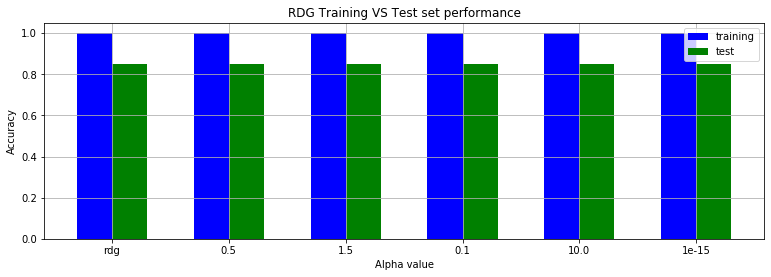

In [822]:
# Plot a grouped bar chart comparing training and test set accuracy
accuracy_train = []
description = []
for fit in fits_train:
    accuracy_train.append(fit.performance_measures['Accuracy'])
    fit.performance_measures['desc'] = fit.performance_measures['desc'].split('_')[0]
    description.append(fit.performance_measures['desc'])
    
accuracy_test = []
for fit in fits_test:
    accuracy_test.append(fit.performance_measures['Accuracy'])

width = 0.3
x = np.arange(len(description))

fig = plt.figure(figsize=[10, 3])
ax = fig.add_axes([0,0,1,1])

ax.bar(x, accuracy_train, color='b', width=width, label="training")
ax.bar(x + width, accuracy_test, color='g', width=width, label="test")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Alpha value')

# title:
ax.set_title('RDG Training VS Test set performance')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(description)
ax.legend()
plt.grid()

# title:
title = 'train_test_bars'

image_path = 'plot_images/' + title + '.png'
fig.savefig(image_path, dpi=fig.dpi)

plt.show()
